#  <span style="font-family: Latin Modern Roman; font-size: 35px; font-weight: bold;"> Project 2. Unsupervised Learning with Recommender Systems </span>

<p align="center" style="display: block; max-width: 100%;">
  <img src="https://cdn.worldvectorlogo.com/logos/last-fm.svg" style="max-width: 20%; height: auto;">
</p>


## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 1. Introduction </span>
<div style="text-align: justify;">

By analyzing patterns in user's behavior, interests, and interactions, recommender systems can provide personalized recommendations to users, directing them toward things they would likely enjoy but would not have found on their own. Increasing user participation in the realm of music streaming and discovery services like Last.fm requires these technologies. The goal of this project is to build a **recommender system** that searches through a vast database of songs, artists, and genres based on listener history, using specific user interactions and artist information to predict and influence future listens. This will help listeners find music that suits their tastes.

A common technique used to provide recommendations based on the user community is **Collaborative Filtering**. This method is distinguished by two main approaches:

- **Memory-Based**: calculates similarities between items or users based on historical data.

- **Model-Based**: involves constructing complex algorithms to predict user preferences. These models can handle large datasets efficiently and are adept at uncovering latent factors that influence listening preferences.


</div>

---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 2. Exploratory Data Analysis </span>

## <span style="font-family: Latin Modern Roman; font-size: 23px;"> 2.1. Data Tables </span>
<div style="text-align: justify;">

**Artists Data:**

This table contains information about music artists listened to and tagged by the users.

* `artistID`: unique identifier for each artist.

* `name`: name of the artist.

* `freq`: how often the artist appears in the dataset.

* `listeners`: number of users who have listened to the artist.

**Tags Data:**

This table contains the set of tags or genres available.

* `tagID`: unique identifier for each tag.

* `tagValue`: name of the tag, which can represent a genre, mood, era, or any other music-related attribute.

**User-Artist Data Data:**

This table captures which artists users have listened to, including a count of listening events.

* `userID`: unique identifier for each user.

* `artistID`: artist listened to by the user.

* `weight`: count of how many times the user has listened to the artist, indicative of the user's preference strength for that artist.

**User-Tagged Artists Data**

This table contains the tags that users have assigned to artists, along with timestamps indicating when the tagging occurred.

* `userID`, `artistID`, `tagID`: identifiers linking users, artists, and tags.

* `day`, `month`, `year`: date when the tag was assigned, providing temporal context.


In [1]:
import pandas as pd 

artists = pd.read_csv('./hetrec2011-lastfm-2k/artists.dat', header=0, sep='\t')
artists_v2 = pd.read_csv('./hetrec2011-lastfm-2k/artists-v2.dat', header=0, sep='\t')
user_tag_artist = pd.read_csv('./hetrec2011-lastfm-2k/user_taggedartists.dat', header=0, sep='\t')
tags = pd.read_csv('hetrec2011-lastfm-2k/tags.dat', header=0, sep='\t', encoding='latin-1')
users = pd.read_csv('hetrec2011-lastfm-2k/user_artists.dat',header=0, sep='\t')


In [2]:
print("Artists Data:")
artists.head()

Artists Data:


,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [3]:
artists.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          17632 non-null  int64 
 1   name        17632 non-null  object
 2   url         17632 non-null  object
 3   pictureURL  17188 non-null  object
dtypes: int64(1), object(3)
memory usage: 551.1+ KB


In [4]:
artists.isna().sum()

id              0
name            0
url             0
pictureURL    444
dtype: int64

In [5]:
print("Artists_v2 Data:")
artists_v2.head()

Artists_v2 Data:


,artistID,name,freq,listeners
0,89,Lady Gaga,611,3798959
1,289,Britney Spears,522,3243214
2,288,Rihanna,484,4542147
3,227,The Beatles,480,3658694
4,300,Katy Perry,473,3721531


In [6]:
artists_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4562 entries, 0 to 4561
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   artistID   4562 non-null   int64 
 1   name       4562 non-null   object
 2   freq       4562 non-null   int64 
 3   listeners  4562 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 142.7+ KB


In [7]:
artists_v2.isna().sum()

artistID     0
name         0
freq         0
listeners    0
dtype: int64

In [8]:
print("User-Tagged Artists Data:")
user_tag_artist.head()

User-Tagged Artists Data:


,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


In [9]:
user_tag_artist.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186479 entries, 0 to 186478
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   userID    186479 non-null  int64
 1   artistID  186479 non-null  int64
 2   tagID     186479 non-null  int64
 3   day       186479 non-null  int64
 4   month     186479 non-null  int64
 5   year      186479 non-null  int64
dtypes: int64(6)
memory usage: 8.5 MB


In [10]:
user_tag_artist.isna().sum()

userID      0
artistID    0
tagID       0
day         0
month       0
year        0
dtype: int64

In [11]:
print("Tags Data:")
tags.head()

Tags Data:


,tagID,tagValue
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [12]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11946 entries, 0 to 11945
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tagID     11946 non-null  int64 
 1   tagValue  11946 non-null  object
dtypes: int64(1), object(1)
memory usage: 186.8+ KB


In [13]:
tags.isna().sum()

tagID       0
tagValue    0
dtype: int64

In [14]:
print("Users Data:")
users.head()

Users Data:


,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [15]:
users.isna().sum()

userID      0
artistID    0
weight      0
dtype: int64

In [16]:
users.value_counts('weight', normalize = True)

weight
1         0.006851
2         0.004513
4         0.003716
3         0.003641
5         0.003425
            ...   
4546      0.000011
4548      0.000011
4551      0.000011
4561      0.000011
352698    0.000011
Length: 5436, dtype: float64

In [17]:
n_users = users['userID'].nunique()
print("Unique User: ", n_users)
n_artists = users['artistID'].nunique()
print("Unique Artists: ", n_artists)

Unique User:  1892
Unique Artists:  17632


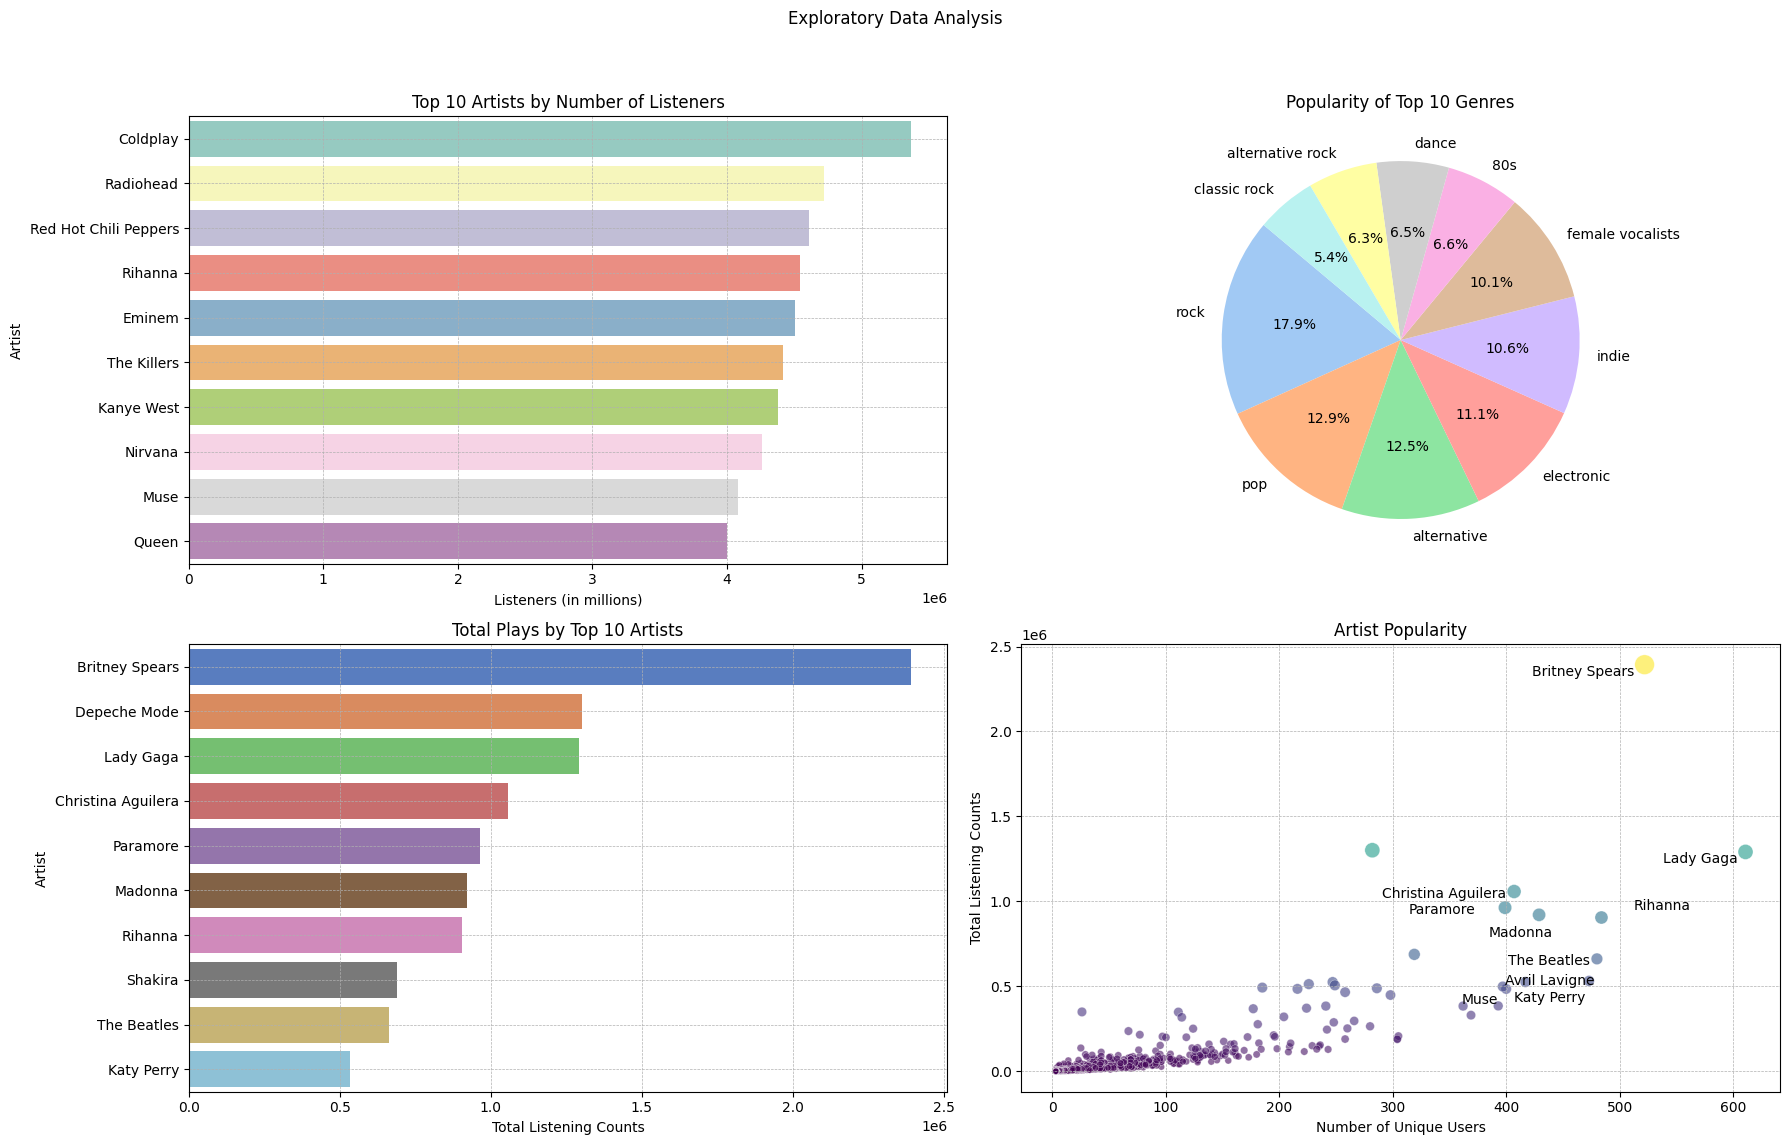

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import warnings

warnings.filterwarnings("ignore")

# Subplot area
fig, axes = plt.subplots(2, 2, figsize = (18, 12))
fig.suptitle('Exploratory Data Analysis')

# Popularity of Artists
top_artists = artists_v2.sort_values(by = 'listeners', ascending = False).head(10)
sns.barplot(x = 'listeners', y = 'name', data = top_artists,  ax = axes[0, 0], palette = 'Set3')
axes[0, 0].set_title('Top 10 Artists by Number of Listeners')
axes[0, 0].set_xlabel('Listeners (in millions)')
axes[0, 0].set_ylabel('Artist')
axes[0, 0].grid(True, which = "both", ls = "--", linewidth = 0.5)

# Popularity of Genres
genre_counts = user_tag_artist.groupby('tagID').size().sort_values(ascending=False).head(10)
top_genres = pd.merge(genre_counts.reset_index(), tags, how = 'left', on = 'tagID')
axes[0, 1].pie(top_genres[0], labels = top_genres['tagValue'], autopct = '%1.1f%%', startangle = 140, colors = sns.color_palette('pastel'))
axes[0, 1].set_title('Popularity of Top 10 Genres')

# Total Plays by Artist (Listening Counts)
total_plays_by_artist = users.groupby('artistID')['weight'].sum().sort_values(ascending=False).head(10)
top_artists_by_plays = pd.merge(total_plays_by_artist.reset_index(), artists_v2, on = 'artistID')
sns.barplot(x = 'weight', y = 'name', data=top_artists_by_plays,  ax = axes[1, 0], palette = 'muted')
axes[1, 0].set_title('Total Plays by Top 10 Artists')
axes[1, 0].set_xlabel('Total Listening Counts')
axes[1, 0].set_ylabel('Artist')
axes[1, 0].grid(True, which = "both", ls = "--", linewidth = 0.5)

# Identifying the top 10 artists by popularity (considering both unique users and total listening counts)
artist_popularity = users.groupby('artistID').agg({'userID': pd.Series.nunique, 'weight': 'sum'})
artist_popularity = artist_popularity.merge(artists_v2[['artistID', 'name']], on='artistID')
top_artists_by_popularity = artist_popularity.sort_values(by = ['userID', 'weight'], ascending = False).head(10)
sns.scatterplot(x = 'userID', y = 'weight', data = artist_popularity, size = 'weight', hue = 'weight', legend = False, alpha = 0.6, sizes = (20, 200),  ax = axes[1, 1], palette = 'viridis')
artist_names = []
for i, row in top_artists_by_popularity.iterrows():
    artist_names.append(plt.text(row['userID'], row['weight'], row['name']))
adjust_text(artist_names)
axes[1, 1].set_title('Artist Popularity')
axes[1, 1].set_xlabel('Number of Unique Users')
axes[1, 1].set_ylabel('Total Listening Counts')
axes[1, 1].grid(True, which = "both", ls = "--", linewidth = 0.5)

plt.tight_layout(rect = [0, 0.03, 1, 0.95])
plt.show()


## <span style="font-family: Latin Modern Roman; font-size: 20px; font-style: italic;"> Insights Gained from Initial Exploration </span>
<div style="text-align: justify;">

These visualizations offer a comprehensive picture of the popularity of different artists and genres within the dataset, as well as specific insights into the tastes and behavior of Last.fm users. Examining each graph in detail:

- **Top 10 Artists by Number of Listeners**: This barplot reveals the artists with the largest unique listener bases. The main takeaway from this is that these artists are popular with a wide range of user segments. The artists at the top of this list, like Coldplay, have effectively reached a large audience, which could make them excellent choices for broad-based recommendations. These artists are probably going to be well-liked by new listeners, based on their large listener numbers, which reflect a general popularity that goes beyond specialist interests.

- **Popularity of Top 10 Genres**: The most popular musical genres and characteristics are displayed in the genre popularity pie chart. Popular music genres on this chart, such pop, rock, and electronic music, are indicative of what most users in this streaming service like to listen to. It represents quite helpful information as it helps to figure out general musical trends, which makes it possible to provide suggestions based on genre that suit the tastes of most people. It also emphasizes how crucial tag-based categorization is for identifying user interests.

- **Total Plays by Top 10 Artists**: Artists with high listening counts demonstrate strong involvement as well as broad popularity when ranked by total plays. An artist like Britney Spears leading this chart suggests a dedicated fan base that listens to her music frequently. This distinction is important for recommendations since artists with a large number of plays may have a strong emotional connection with their audience and encourage return visits. Thus, suggests the possibility of fostering user loyalty and enduring interest. 

- **Artist Popularity**: This scatterplot combines the dimensions of unique listener counts and total plays to map out the landscape of artist popularity more comprehensively. It displays a range of artist profiles, from those with high unique users and total reproductions and to the ones that have lower listeners and total plays. Most importantly, it distinguishes between artists with a broad but perhaps shallower appeal (high unique users but lower plays per user) and those who, although having fewer listeners, induce high engagement (high plays but lower unique user counts). This perspective helps customize suggestions to match user preferences for breadth (new artists to discover) versus depth (artists they could get deeply engaged with).

</div>

---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 3. Memory Based Approach</span>

<div style="text-align: justify;">
 
In Collaborative Filtering, there are two key approaches: Memory-based approach and Model-based approach. The Memory-Based approach seeks to identify similar users based on Cosine Similarity or the Pearson correlation coefficient, and then takes the weighted average of the ratings.

There are two main types of neighborhood-based algorithms:

- **User Based**: In this scenario, ratings provided by users similar to a target user A are used to make recommendations for this user A. The predicted ratings for A are computed as the weighted average values of these ratings from the *peer group* for each item. Operations are calculated with a $m × n$ matrix $R = [r_{ij}]$ containing $m$ users and $n$ items. Before initiating this method, an approach is adopted whereby rows are compared, effectively comparing User 1 and User 2 as vectors. It is crucial to mention that to avoid penalizing any user, rather than standardization, normalization is applied.


- **Item Based**: To generate recommendations for a target item B, the initial step involves identifying a set $S$ of items that bear the closest resemblance to item B. Subsequently, to predict the rating of any user A for item B, the ratings within the set, as specified by A, are considered. The weighted average of these ratings is then used to estimate the predicted rating of user A for item B. This process is based on the principle that users who have shown a preference for items similar to B are likely to feel the same way about B itself.

While both Pearson correlation coefficient and Cosine Similarity are applied in the user-based approach, the item-based approach additionally incorporates the Adjusted Cosine metric.
</div>

In [19]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import cornac
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN

## <span style="font-family: Latin Modern Roman; font-size: 23px;"> 3.1. User Based</span>

In [20]:
# UserKNN methods
VERBOSE = False
K = 50  # Number of nearest neighbors

uknn_cosine = UserKNN(
  k = K, similarity = "cosine", name = "UserKNN-Cosine", verbose = VERBOSE
)
uknn_cosine_mc = UserKNN(
  k = K, similarity = "cosine", mean_centered = True, name = "UserKNN-Cosine-MC", verbose = VERBOSE
)
uknn_pearson = UserKNN(
  k = K, similarity = "pearson", name = "UserKNN-Pearson", verbose = VERBOSE
)
uknn_pearson_mc = UserKNN(
  k = K, similarity = "pearson", mean_centered = True, name = "UserKNN-Pearson-MC", verbose = VERBOSE
)

In [21]:
SEED = 42

# Nomalize data weights
scaler = MinMaxScaler()

users_copy = users.copy()
users_copy['weight'] = scaler.fit_transform(users_copy[['weight']])
data = users_copy.astype({'userID': int, 'artistID': int}).to_records(index = False)
result = list(data)
ratio_split = RatioSplit(result, test_size = 0.1, seed = SEED, verbose = VERBOSE)

cornac.Experiment(
  eval_method = ratio_split,
  models = [uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
  metrics = [cornac.metrics.RMSE(), cornac.metrics.MAE()],
).run()


TEST:
...
                   |    MAE |   RMSE | Train (s) | Test (s)
------------------ + ------ + ------ + --------- + --------
UserKNN-Cosine     | 0.0024 | 0.0033 |    0.1089 |   0.4060
UserKNN-Cosine-MC  | 0.0024 | 0.0033 |    0.0981 |   0.3932
UserKNN-Pearson    | 0.0024 | 0.0033 |    0.0902 |   0.3898
UserKNN-Pearson-MC | 0.0024 | 0.0033 |    0.0898 |   0.3885



<div style="text-align: justify;">

All the models have equivalent error indicators; $MAE = 0.0024$ and $RMSE = 0.0033$ , which means that in terms of predictive accuracy, there is no difference between them. Therefore, other factors such as computational efficiency become more relevant. Given these considerations, the `UserKNN-Pearson-MC` model represents a good balance between accuracy and efficiency in training and test time, which makes it a suitable choice.

</div>

In [22]:
users_df = users_copy.copy()  
users_df.set_index("userID", inplace = True)

In [23]:
def user_profiling(UID, model, user_df, TOPK = 5):

# User-item interaction matrix from the trained model
  rating_mat = model.train_set.matrix

  UIDX = list(model.train_set.uid_map.items())[UID][0]

  print(f"UserID = {UIDX}")
  print("-" * 35)
  print(user_df.loc[UIDX])

  ratings = pd.DataFrame(rating_mat.toarray())
  user_ratings = ratings.loc[UID]
  top_rated_items = np.argsort(user_ratings)[-TOPK:]
  print(f"\nTOP {TOPK} RECOMMENDED ARTISTS FOR USER {UID}:")
  print("-" * 35)
  print(user_df.iloc[top_rated_items.array])

top_rated_items = user_profiling(8, uknn_pearson_mc, users_df)

UserID = 773
-----------------------------------
        artistID    weight
userID                    
773           70  0.001630
773           88  0.002796
773          154  0.008991
773          159  0.001809
773          163  0.004134
773          173  0.003159
773          197  0.008310
773          198  0.004860
773          202  0.003323
773          209  0.002711
773          220  0.004811
773          227  0.021582
773          234  0.002892
773          250  0.002824
773          436  0.019921
773          521  0.001803
773          614  0.001622
773          707  0.002813
773          709  0.002260
773          726  0.002461
773          867  0.003377
773          868  0.006966
773          959  0.001999
773         1146  0.003229
773         1351  0.003431
773         1372  0.002711
773         1981  0.007207
773         1984  0.007604
773         2612  0.002073
773         2637  0.001732
773         2893  0.001795
773         3213  0.002453
773         3625  0.003547
773   

In [24]:
def uknn_get_scores(UID, model, user_df, TOPK = 5):

    recommendations, scores = model.rank(UID)
    print(f"\nTOP {5} RECOMMENDATIONS OF ARTISTS FOR USER ID {UID}:")
    denormed_scores = scaler.inverse_transform(scores[recommendations[:TOPK]].reshape(-1, 1))
    print("Scores:", denormed_scores)
    recommended_items_df = user_df.iloc[recommendations[:TOPK]]
    recommended_items_df.reset_index(inplace = True)
    merged_df = pd.merge(recommended_items_df, artists, left_on = 'artistID', right_on = 'id', how = 'left')
    merged_df = merged_df.drop(["id", "url", "pictureURL"], axis = 1)
    merged_df = merged_df.set_index("artistID")
    print(merged_df)

uknn_get_scores(2, uknn_cosine, users_df)


TOP 5 RECOMMENDATIONS OF ARTISTS FOR USER ID 2:
Scores: [[33529.71077983]
 [24493.178895  ]
 [21309.16162565]
 [19014.41882634]
 [15130.38046737]]
          userID    weight                name
artistID                                      
3032         213  0.001225        Comeback Kid
5803         336  0.001092       Banco de Gaia
292          252  0.001392  Christina Aguilera
816           80  0.003896   A Day to Remember
1022          28  0.000017        Dance Nation


## <span style="font-family: Latin Modern Roman; font-size: 23px;"> 3.2. Item Based</span>

In [25]:
# ItemKNN methods
VERBOSE = False
K = 50  # Number of nearest neighbors

iknn_cosine = ItemKNN(
  k = K, similarity = "cosine", name = "ItemKNN-Cosine", verbose=VERBOSE
)
iknn_pearson = ItemKNN(
  k = K, similarity = "pearson", name = "ItemKNN-Pearson", verbose=VERBOSE
)
iknn_pearson_mc = ItemKNN(
  k = K, similarity = "pearson", mean_centered = True, name = "ItemKNN-Pearson-MC", verbose = VERBOSE
)
iknn_adjusted = ItemKNN(
  k = K, similarity = "cosine", mean_centered = True, name = "ItemKNN-AdjustedCosine", verbose = VERBOSE
)

In [26]:
SEED = 42

data = users_copy.astype({'userID': object, 'artistID': object}).to_records(index = False)
result = list(data)
ratio_split = RatioSplit(result, test_size = 0.1, seed = SEED, verbose = VERBOSE)

cornac.Experiment(
  eval_method = ratio_split, 
  models = [iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
  metrics = [cornac.metrics.RMSE(), cornac.metrics.MAE()],
).run()



TEST:
...
                       |    MAE |   RMSE | Train (s) | Test (s)
---------------------- + ------ + ------ + --------- + --------
ItemKNN-Cosine         | 0.0023 | 0.0031 |    1.7457 |   0.4638
ItemKNN-Pearson        | 0.0022 | 0.0030 |    1.7317 |   0.4552
ItemKNN-Pearson-MC     | 0.0021 | 0.0029 |    1.7181 |   0.4786
ItemKNN-AdjustedCosine | 0.0021 | 0.0029 |    1.6568 |   0.4460



<div style="text-align: justify;">

In this case, it is easier to choose the best model since `ItemKNN-AdjustedCosine` is the one that presents lower error metrics with $MAE = 0.0021$ and $RMSE = 0.0029$, indicating that it has higher prediction accuracy and consistency in the generated recommendations, since both errors are minimal.

</div>

In [27]:
items_df = users_copy.copy() 
items_df.set_index("artistID", inplace = True)

In [28]:
def item_profiling(UID, model, item_df, TOPK = 5):

    # User-item interaction matrix from the trained model
    rating_mat = model.train_set.matrix

    UIDX = list(model.train_set.iid_map.items())[UID][0]

    print(f"ArtistID = {UIDX}")
    print("-" * 35)
    print(item_df.loc[UIDX])

    # Ratings between the selected user and all items
    ratings = pd.DataFrame(rating_mat.toarray())
    item_ratings = ratings.iloc[UID]
    top_rated_items = np.argsort(item_ratings)[-TOPK:]
    print(f"\nTOP {TOPK} RECOMMENDED ARTISTS FOR USER ID {UID}:")
    print("-" * 35)
    print(item_df.iloc[top_rated_items.array])

top_rated_items = item_profiling(2, iknn_adjusted, items_df)

ArtistID = 8841
-----------------------------------
userID    644.000000
weight      0.000113
Name: 8841, dtype: float64

TOP 5 RECOMMENDED ARTISTS FOR USER ID 2:
-----------------------------------
          userID    weight
artistID                  
2977         286  0.000519
475           65  0.000298
377           32  0.000476
173            5  0.000680
913           25  0.000250


In [29]:
def itemknn_get_scores(UID, model, item_df, TOPK = 5):

    recommendations, scores = model.rank(UID)
    print(f"\nTOP {5} RECOMMENDATIONS OF ARTISTS FOR USER ID {UID}:")
    denormed_scores = scaler.inverse_transform(scores[recommendations[:TOPK]].reshape(-1, 1))
    print("Scores:", denormed_scores)
    recommended_items_df = item_df.iloc[recommendations[:TOPK]]
    recommended_items_df.reset_index(inplace = True)
    merged_df = pd.merge(recommended_items_df, artists, left_on = 'artistID', right_on = 'id', how = 'left')
    merged_df = merged_df.drop(["id", "url", "pictureURL"], axis = 1)
    merged_df = merged_df.set_index("artistID")
    print(merged_df)

itemknn_get_scores(2, iknn_adjusted, items_df)


TOP 5 RECOMMENDATIONS OF ARTISTS FOR USER ID 2:
Scores: [[4339.99996061]
 [4339.99996061]
 [4339.99996061]
 [4339.99996061]
 [4339.99996061]]
          userID    weight          name
artistID                                
439          299  0.000442  Los Hermanos
2083         318  0.001270        M.I.A.
67           183  0.001406       Madonna
2939         231  0.000454           JLS
982          149  0.000831  Foo Fighters


---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 4. Model Based Approach</span>

<div style="text-align: justify;">

This approach uses machine learning to find user ratings of unrated items. Model-based recommender systems usually have several advantages over neighborhood-based methods. For example, space efficiency, the size of the learned model is usually much smaller than the original rating matrix. Therefore, the space requirements are usually quite low. There is also the speed of training and prediction. One problem with neighborhood-based methods is that the preprocessing stage is quadratic in the number of users or the number of items. Model-based systems are usually much faster in the preprocessing stage of building the trained model. 

And finally, to avoid overfitting, a serious problem in many machine learning algorithms where the prediction is overly influenced by random artifacts in the data. This problem is also encountered in classification and regression models.
In model based approach there are two types of decompositions: 

- **Singular Value Decomposition (SVD)**: It is a linear algebra technique that decomposes a matrix into three matrices: a matrix of left singular vectors, a diagonal matrix of singular values, and a matrix of right singular vectors. In the context of collaborative filtering, SVD is used to reduce the dimensionality of the user-item interaction matrix and capture the underlying latent features of users and items. When it comes to capturing data variability, SVD is an effective method as it captures the diversity in users' preferences and item features by breaking down the user-item interaction matrix and extracting latent features that represent users' preferences and item characteristics.

- **Matrix Factorization (MF)**: It is also a class of collaborative filtering models that decomposes the user-item interaction matrix into the product of two lower-rank matrices, capturing the low-rank structure of the user-item interactions. In this approach, latent matrices are used to represent users and items in a lower-dimensional feature space. Unlike SVD, the flexibility, scalability, personalization, and ability to handle various recommendation scenarios make matrix factorization usually deliver better results for many collaborative filtering applications, often leading to better recommendation performance compared to traditional methods.
</div>

## <span style="font-family: Latin Modern Roman; font-size: 23px;"> 4.1. Singular Value Decomposition (SVD)</span>

In [30]:
from cornac.models import SVD

In [31]:
SEED = 42

data = users_copy.astype({'userID': object, 'artistID': object}).to_records(index = False)
result = list(data)
ratio_split = RatioSplit(result, test_size = 0.1, seed = SEED, verbose = VERBOSE)

svd_models = []
k_values = np.arange(100, 500, 50)
for k in k_values:
    svd_models.append(SVD(name = 'SVD'+str(k), k = k))

# Metrics
rmse = cornac.metrics.RMSE()

svd_experiment = cornac.Experiment(eval_method = ratio_split,
                models = svd_models,
                show_validation = True,
                metrics = [cornac.metrics.RMSE()],
                )
svd_experiment.run()


TEST:
...
       |   RMSE | Train (s) | Test (s)
------ + ------ + --------- + --------
SVD100 | 0.0033 |    0.1026 |   0.0958
SVD150 | 0.0034 |    0.1558 |   0.0947
SVD200 | 0.0034 |    0.1870 |   0.0936
SVD250 | 0.0034 |    0.2446 |   0.0928
SVD300 | 0.0035 |    0.2796 |   0.0925
SVD350 | 0.0035 |    0.3408 |   0.0926
SVD400 | 0.0035 |    0.3673 |   0.0962
SVD450 | 0.0035 |    0.4531 |   0.0988



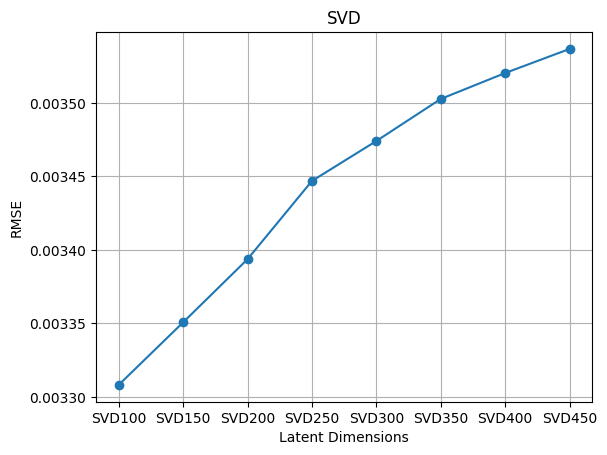

In [32]:
metric_values = []
names_models = []
for i in range(len(svd_experiment.result)):
    metric_values.append(svd_experiment.result[i].metric_avg_results.get('RMSE'))
    names_models.append(svd_experiment.result[i].model_name)

plt.xlabel('Latent Dimensions')
plt.ylabel('RMSE')
plt.title('SVD')
plt.plot(names_models, metric_values, 'o-')
plt.grid(True)
plt.show()

In [33]:
result = list(data)

# Instantiate an evaluation method to split data into train and test sets.
ratio_split = cornac.eval_methods.RatioSplit(
    data = users_copy.values, test_size = 0.1, verbose = True
)

# Instantiate the models of interest
bo = cornac.models.BaselineOnly(
    max_iter = 30, learning_rate = 0.01, lambda_reg = 0.02, verbose = True
)
svd = cornac.models.SVD(
    k = 400, max_iter = 30, learning_rate = 0.01, lambda_reg = 0.02, verbose = True
)

# Instantiate evaluation measures
mae = cornac.metrics.MAE()
rmse = cornac.metrics.RMSE()

# Instantiate and run an experiment.
cornac.Experiment(eval_method = ratio_split, models = [bo, svd], metrics = [mae, rmse]).run()

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 1892
Number of items = 16539
Number of ratings = 83550
Max rating = 1.0
Min rating = 0.0
Global mean = 0.0
---
Test data:
Number of users = 1892
Number of items = 16539
Number of ratings = 8162
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 1892
Total items = 16539

[BaselineOnly] Training started!


  0%|          | 0/30 [00:00<?, ?it/s]

Optimization finished!

[BaselineOnly] Evaluation started!


Rating:   0%|          | 0/8162 [00:00<?, ?it/s]


[SVD] Training started!


  0%|          | 0/30 [00:00<?, ?it/s]

Optimization finished!

[SVD] Evaluation started!


Rating:   0%|          | 0/8162 [00:00<?, ?it/s]


TEST:
...
             |    MAE |   RMSE | Train (s) | Test (s)
------------ + ------ + ------ + --------- + --------
BaselineOnly | 0.0022 | 0.0031 |    0.0135 |   0.1756
SVD          | 0.0025 | 0.0034 |    0.5399 |   0.1633



In [34]:
def recommend_products(index, model, data, num_artists = 5):

    print('NAME OF MODEL:', svd.name)
    
    # Rank all test items for a given user.
    df_rank = pd.DataFrame({'ranked_items': model.rank(index)[0], 'item_scores': model.rank(index)[1]}, 
                           columns=['ranked_items', 'item_scores'])
    print('TARGET USER ID', users_copy.iloc[index].userID)

    df_rank.sort_values('item_scores', ascending = False, inplace = True)
    artists.set_index('id', inplace = True)
    recommended_artists_ids = data.iloc[df_rank.head(num_artists).ranked_items.values]['artistID'].values
    recommended_artists_names = artists.loc[recommended_artists_ids, 'name']
    print('RECOMMENDED ARTISTS:', recommended_artists_names)
    denormed_scores = scaler.inverse_transform(df_rank.head(num_artists).item_scores.to_frame())
    print('PREDICTED SCORES: ', denormed_scores)
recommend_products(1, svd, users_copy)

NAME OF MODEL: SVD
TARGET USER ID 2.0
RECOMMENDED ARTISTS: id
5073     Juno Reactor
1988      The Subways
1896         Magazine
72       Depeche Mode
1369    Black Sabbath
Name: name, dtype: object
PREDICTED SCORES:  [[9026.769 ]
 [7100.5854]
 [6272.428 ]
 [5335.9673]
 [5281.8657]]


In [35]:
nusers = 20
nitems = 20


plt.figure(figsize=(10, 10))
plt.imshow(R[:nusers, :nitems], cmap="jet")
plt.xlabel("item")
plt.ylabel("user")
plt.title("True ratings")
plt.colorbar()



NameError: name 'R' is not defined

<Figure size 1000x1000 with 0 Axes>

## <span style="font-family: Latin Modern Roman; font-size: 23px;"> 4.2. Matrix Factorization (MF)</span>

In [36]:
from cornac.models import MF, NMF, BaselineOnly

In [37]:
data = users_copy.astype({'userID': object, 'artistID': object}).to_records(index = False)
result = list(data)

K = 10
VERBOSE = False
SEED = 42

lbd = 0.01
baseline = BaselineOnly(max_iter = 20, learning_rate = 0.01, lambda_reg = lbd, verbose = VERBOSE)
mf1 = MF(k = K, max_iter = 20, learning_rate = 0.01, lambda_reg = 0.0, use_bias = False, verbose = VERBOSE, seed = SEED, name = f"MF(K = {K})")
mf2 = MF(k = K, max_iter = 20, learning_rate = 0.01, lambda_reg = lbd, use_bias = False, verbose = VERBOSE, seed = SEED, name = f"MF(K = {K},lambda = {lbd:.4f})")
mf3 = MF(k = K, max_iter = 20, learning_rate = 0.01, lambda_reg = lbd, use_bias = True, verbose = VERBOSE, seed = SEED, name = f"MF(K = {K},bias)")
nmf = NMF(k = K, max_iter = 200, learning_rate = 0.01, use_bias = False, verbose = VERBOSE, seed = SEED, name = f"NMF(K = {K})")
ratio_split = RatioSplit(result, test_size = 0.1, seed = SEED, verbose = VERBOSE)
cornac.Experiment(eval_method = ratio_split,
                    models = [baseline, mf1, mf2, mf3, nmf],
                    metrics = [cornac.metrics.RMSE()],
                    ).run()
  
mf_models ={'baseline': baseline, 'mf1': mf1, 'mf2': mf2, 'mf3': mf3, 'nmf': nmf}


TEST:
...
                           |   RMSE | Train (s) | Test (s)
-------------------------- + ------ + --------- + --------
BaselineOnly               | 0.0032 |    0.0024 |   0.0901
MF(K = 10)                 | 0.0031 |    0.0192 |   0.1051
MF(K = 10,lambda = 0.0100) | 0.0031 |    0.0177 |   0.0992
MF(K = 10,bias)            | 0.0032 |    0.0188 |   0.0937
NMF(K = 10)                | 0.0032 |    0.3849 |   0.1001



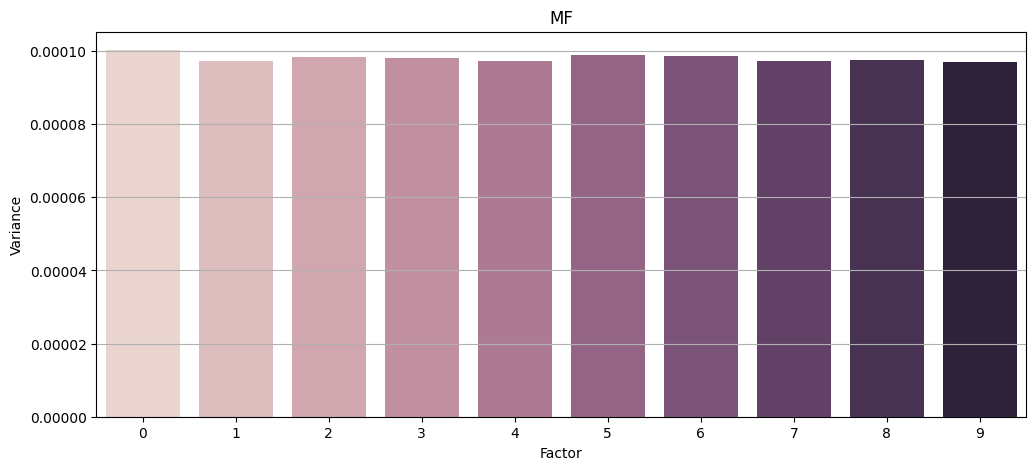

In [38]:
K = 10
model = mf_models.get('mf3')
var_df = pd.DataFrame({"Factor": np.arange(K), "Variance": np.var(model.i_factors, axis=0)})
fig, ax = plt.subplots(figsize=(12, 5))
plt.title('MF')
plt.grid(True)
sns.barplot(x = "Factor", y = "Variance", data = var_df, hue = 'Factor', legend = False, ax = ax);

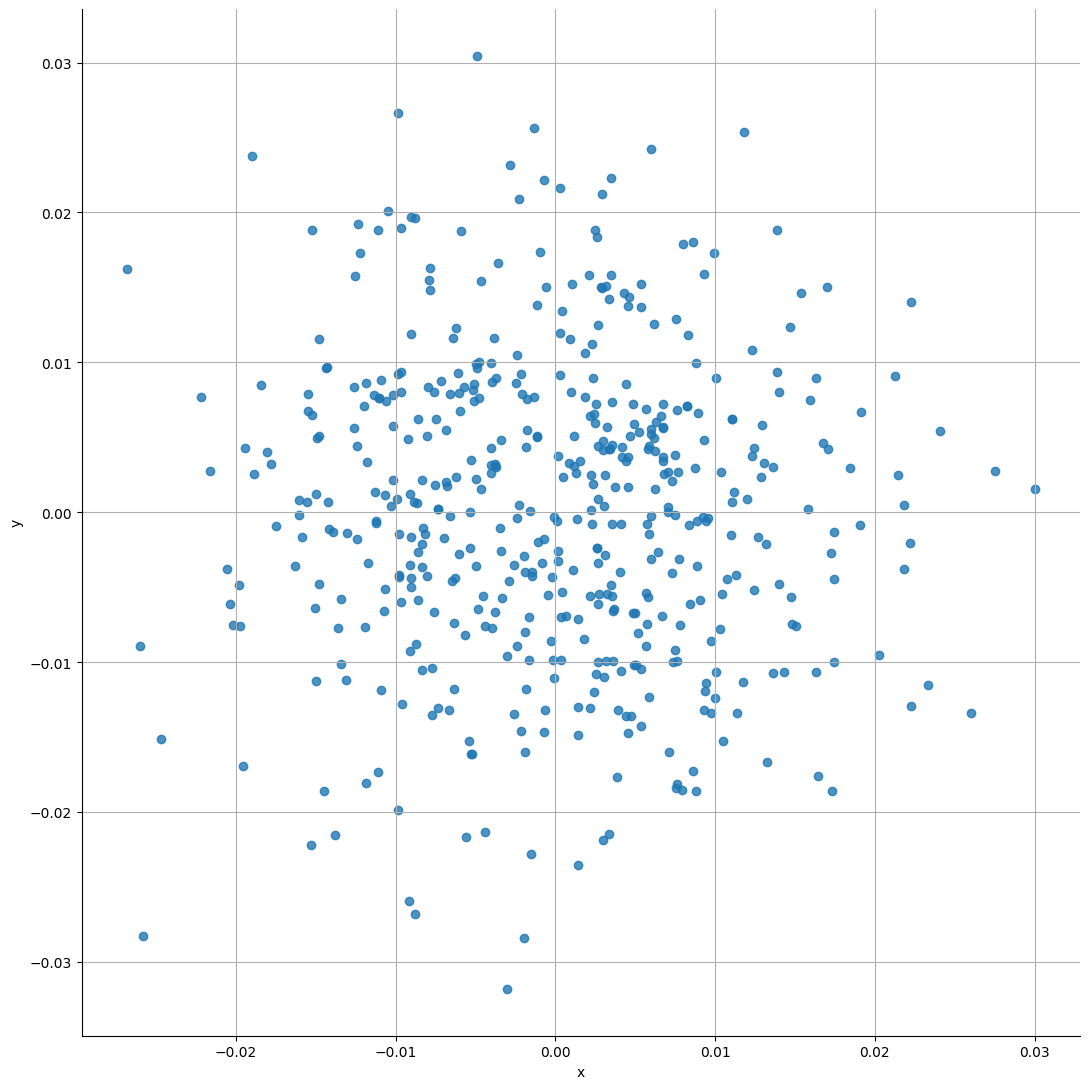

In [39]:
TOP2F = (0, 2)
SAMPLE_SIZE = 500

mf = model
rng = np.random.RandomState(42)
sample_inds = rng.choice(np.arange(mf.i_factors.shape[0]), size = SAMPLE_SIZE)
sample_df = pd.DataFrame(data = mf.i_factors[sample_inds][:, TOP2F], columns = ["x", "y"])
sns.lmplot(x = "x", y="y", data = sample_df, height=11.0, fit_reg = False)
plt.grid(True)

In [40]:
def pick_centroids(data, k):
    indexes = np.random.choice(len(data), size=k, replace=False)
    centroids = data[indexes]
    return centroids

def assign_cluster(data, centroids):
    # Pairwise squared L2 distances. Shape [n, k]
    distances = ((data[:, np.newaxis] - centroids)**2).sum(axis=2)
    # find closest centroid index. Shape [n]
    clusters = np.argmin(distances, axis=1)
    return clusters

def update_centroids(data, clusters, k):
    # Mean positions of data within clusters
    centroids = [np.mean(data[clusters == i], axis=0) for i in range(k)]
    return np.array(centroids)

In [41]:
class KMEANS:
    def __init__(self, k):
        self.k = k
        
    def fit(self, data, steps=20):
        self.centroids = pick_centroids(data, self.k)
        for step in range(steps):
            clusters = assign_cluster(data, self.centroids)
            self.centroids = update_centroids(data, clusters, self.k)
            
    def predict(self, data):
        return assign_cluster(data, self.centroids)

In [42]:
kmeans = KMEANS(k=3)
data = sample_df.to_numpy()
kmeans.fit(data)
clusters = kmeans.predict(data)

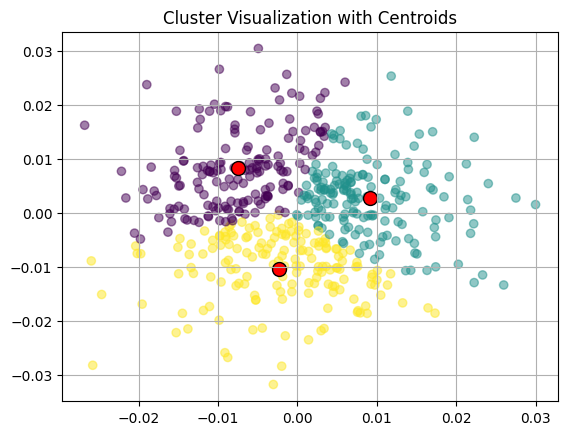

In [43]:
plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', alpha=0.5) 
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c="red", s=100, edgecolor='black', label='Centroids')
plt.title('Cluster Visualization with Centroids')  
plt.grid(True)
plt.show()

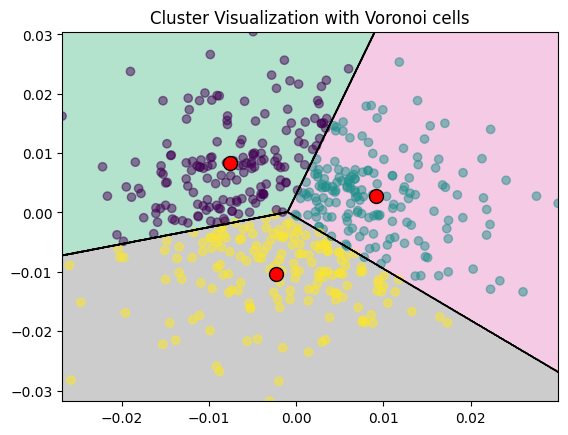

In [44]:
def plot_decision_boundaries(clusterer, X, resolution=1000):
    plt.figure()
    mins = X.min(axis=0) 
    maxs = X.max(axis=0) 
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.title('Cluster Visualization with Voronoi cells') 
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k")
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', alpha=0.5) 
    plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c="red", s=100, edgecolor='black', label='Centroids')
    plt.show()
plot_decision_boundaries(kmeans, data) 

---

## <span style="font-family: Latin Modern Roman; font-size: 25px;"> 5. Conclusions </span>

## <span style="font-family: Latin Modern Roman; font-size: 23px;"> 5.1. Memory-Based Approach (User Based/Item Based)</span>

<div style="text-align: justify;">
 
- In the User Based approach, artists were recommended based on the similarity of preferences among users. The list of recommendations includes artists such as *Comeback Kid* and *Banco de Gaia*, which are popular among users similar to `UserID = 2`.

- In the Item Based approach, artists were recommended based on the similarity of the user's favorite artists. The list of recommendations includes artists such as *Los Hermanos* and *M.I.A.*, which are similar to the artists that user `UserID = 2` has listened to previously.

</div>

## <span style="font-family: Latin Modern Roman; font-size: 23px;"> 5.2. Model-Based Approach (SVD)</span>

- In the model-based approach, Singular Value Decomposition (SVD) was used to generate recommendations. The list of recommendations includes artists such as *The Presets* and *Lee Ryan*, along with associated prediction scores. These scores represent the estimated probability that `UserID = 2` will enjoy each artist, according to the trained SVD model.
    
## <span style="font-family: Latin Modern Roman; font-size: 23px;"> 5.3. Results' Comparisons</span>

- It is observed that the recommendations from the model-based approach with SVD appear to significantly differ from the recommendations of the memory-based approaches. This may be attributable to the model-based approach's ability to capture more complex relationships between users and artists, as well as to learn more subtle patterns in the data.

- While recommendations from memory-based approaches may be based on user or item similarity, recommendations from the model-based approach can take into account a broader range of factors and latent characteristics of users and artists.

</div>